In [31]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jvp, jit
import jax
from functools import partial

a = 2.4 # 2aB
nH = 6
atoms = ""
for i in range(nH):
    atoms += f"H {i*a:.5f} 0.00000 0.00000 \n"

mol = gto.M(atom=atoms, basis="sto6g", unit='B', spin=0, verbose=4)
mol.build()

mf = scf.RHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()[0]

System: uname_result(system='Linux', node='yichi-thinkpad', release='4.4.0-26100-Microsoft', version='#7309-Microsoft Fri Jan 01 08:00:00 PST 2016', machine='x86_64')  Threads 12
Python 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
numpy 1.24.3  scipy 1.14.1  h5py 3.12.1
Date: Sat Jan 24 13:05:06 2026
PySCF version 2.8.0
PySCF path  /home/yichi/research/software/lno_pyscf
GIT HEAD (branch master) ef75f4190e4de208685670651dc6c467f72b6794

[ENV] PYSCF_EXT_PATH /home/yichi/research/software/pyscf
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 6
[INPUT] num. electrons = 6
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = B
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000

CPU time:       100.34


******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpflfyvkb8
max_memory 4000 MB (current use 995 MB)
Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
init E= -2.08549122715034
  HOMO = -0.18992207883996  LUMO = 0.0358048604951934
cycle= 1 E= -2.96127373262217  delta_E= -0.876  |g|= 0.0821  |ddm|= 1.72
  HOMO = -0.287781773079973  LUMO = 0.114582300015998
cycle= 2 E= -2.96818663706993  delta_E= -0.00691  |g|= 0.0333  |ddm|= 0.209
  HOMO = -0.296506007062908  LUMO = 0.12902790402714
cycle= 3 E= -2.96956577079359  delta_E= -0.00138  |g|= 0.00493  |ddm|= 0.118
  HOMO = -0.298817005089559  LUMO = 0.128871011498043
cycle= 4 E= -2.9695874820821  delta_

-0.16645575766860862

In [32]:
# example for PT2
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 50,
            'seed': 2,
            'walker_type': 'rhf',
            'trial': 'cisd_hf1',
            'dt':0.005,
            'free_projection':False,
            'ad_mode':None,
            'use_gpu': False,
            }

from ad_afqmc.prop_unrestricted import prop_unrestricted
prop_unrestricted.prep_afqmc(mycc,options,chol_cut=1e-5)
# prop_unrestricted.run_afqmc(options,nproc=1)
option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (3, 3)
# Number of basis functions: 6
# Number of Cholesky vectors: 11
#


In [33]:
import numpy as np
from jax import random
from jax import numpy as jnp
from functools import partial
from ad_afqmc import config, stat_utils
from ad_afqmc.prop_unrestricted import prop_unrestricted, sampling
import time

In [34]:
config.setup_jax()
MPI = config.setup_comm()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print = partial(print, flush=True)

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (
    prop_unrestricted._prep_afqmc())

init_time = time.time()
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

### initialize propagation
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)
h0 = ham_data['h0']

prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    raise ValueError(
        "Initial overlaps are zero. Pass walkers with non-zero overlap."
    )
prop_data["key"] = random.PRNGKey(seed + rank)

prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
prop_data["n_killed_walkers"] = 0
o, e0, e1 = trial.calc_energy_cisd_hf(
    prop_data['walkers'], ham_data, wave_data)
eci = h0 + e1/o
o_init = jnp.array(jnp.sum(o) / prop.n_walkers)
e0_init = jnp.array(jnp.sum(e0) / prop.n_walkers)
eci_init = jnp.array(jnp.sum(eci) / prop.n_walkers)
prop_data["e_estimate"] = e0
prop_data["pop_control_ene_shift"] = prop_data["e_estimate"]

comm.Barrier()
if rank == 0:
    print(f'# Propagating with {options["n_walkers"]*size} walkers')
    print("# Equilibration sweeps:")
    print("#   Iter \t olp_T/G \t Energy_HF \t Energy_CI \t Walltime")
    print(f"  {0:5d} \t {o_init:.6f} \t {e0_init:.6f} \t {eci_init:.6f} \t "
          f"  {time.time() - init_time:.2f}")
comm.Barrier()

sampler_eq = sampling.sampler_cisd_hf1(
    n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10, n_chol = sampler.n_chol)

eci_eq_list = np.empty(options['n_eql'])
for i,n in enumerate(range(1,options["n_eql"]+1)):
    prop_data, (wt, olp, ehf, e1) =\
        sampler_eq.propagate_phaseless(prop_data, ham_data, prop, trial, wave_data)
    eci = h0 + e1/olp
    eci_eq_list[i] = eci
    print(f"  {n:5d} \t {olp:.6f} \t {ehf:.6f} \t {eci:.6f} \t {time.time() - init_time:.2f}")

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 6
# nelec: (3, 3)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 50
# seed: 2
# walker_type: rhf
# trial: cisd_hf1
# dt: 0.005
# free_projection: False
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Propagating with 50 walkers
# Equilibration sweeps:
#   Iter 	 olp_T/G 	 Energy_HF 	 Energy_CI 	 Walltime
      0 	 1.000000 	 -2.969577 	 -3.136031 	   1.75
      1 	 1.192160 	 -3.094483 	 -3.132071 	 3.80
      2 	 1.184835 	 -3.100612 	 -3.136506 	 5.56
      3 	 1.207745 	 -3.113986 	 -3.132799 	 6.33


In [35]:
nsamples = 50
ehf_sp_list = np.empty(nsamples)
eci_sp_list = np.empty(nsamples)
for i,n in enumerate(range(1,nsamples+1)):
    prop_data, (wt, olp, ehf, e1) =\
        sampler.propagate_phaseless(prop_data, ham_data, prop, trial, wave_data)
    eci = h0 + e1/olp
    ehf_sp_list[i] = ehf
    eci_sp_list[i] = eci
    print(f"  {n:5d} \t {olp:.6f} \t {ehf:.6f} \t {eci:.6f} \t {time.time() - init_time:.2f}")

      1 	 1.263497 	 -3.151059 	 -3.131120 	 9.57
      2 	 1.206954 	 -3.106105 	 -3.135611 	 9.65
      3 	 1.193676 	 -3.101752 	 -3.138784 	 9.74
      4 	 1.187271 	 -3.096444 	 -3.131025 	 9.82
      5 	 1.186001 	 -3.098670 	 -3.133831 	 9.88
      6 	 1.200032 	 -3.103866 	 -3.135356 	 9.95
      7 	 1.274075 	 -3.153586 	 -3.125873 	 10.02
      8 	 1.248940 	 -3.134627 	 -3.130153 	 10.09
      9 	 1.203122 	 -3.109527 	 -3.132553 	 10.18
     10 	 1.168928 	 -3.090143 	 -3.131556 	 10.25
     11 	 1.155395 	 -3.081117 	 -3.133275 	 10.30
     12 	 1.180220 	 -3.091152 	 -3.130931 	 10.36
     13 	 1.212243 	 -3.095632 	 -3.133028 	 10.42
     14 	 1.263836 	 -3.127542 	 -3.135113 	 10.47
     15 	 1.269363 	 -3.136751 	 -3.134721 	 10.53
     16 	 1.294387 	 -3.168422 	 -3.133698 	 10.59
     17 	 1.236395 	 -3.132236 	 -3.132826 	 10.65
     18 	 1.175939 	 -3.087043 	 -3.132093 	 10.72
     19 	 1.189429 	 -3.095960 	 -3.133193 	 10.77
     20 	 1.207310 	 -3.109620 	 -3.1

AFQMC/RHF average = -3.113965225002443, std = 0.0028988438114736447
AFQMC/CISD_RHF average = -3.1342542528071875, std = 0.0008514503016117166


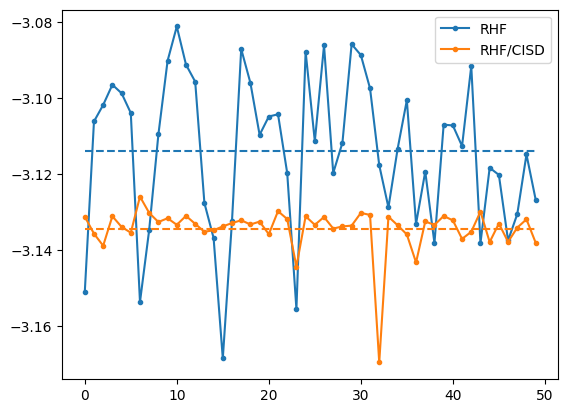

In [36]:
from matplotlib import pyplot as plt
ehf_avg = ehf_sp_list.mean()
ehf_avg_std = np.std(ehf_sp_list, ddof=1) / np.sqrt(len(ehf_sp_list))
eci_avg = eci_sp_list.mean()
eci_avg_std = np.std(eci_sp_list, ddof=1) / np.sqrt(len(eci_sp_list))
print(f'AFQMC/RHF average = {ehf_avg}, std = {ehf_avg_std}')
print(f'AFQMC/CISD_RHF average = {eci_avg}, std = {eci_avg_std}')
plt.plot(ehf_sp_list,'.-',label='RHF',color='C0')
plt.plot([ehf_avg]*len(ehf_sp_list),'--',color='C0')
plt.plot(eci_sp_list,'.-',label='RHF/CISD',color='C1')
plt.plot([eci_avg]*len(eci_sp_list),'--',color='C1')
plt.legend()
plt.show()

In [37]:
# example for PT2
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 50,
            'seed': 2,
            'walker_type': 'rhf',
            'trial': 'cisd_hf2',
            'dt':0.005,
            'free_projection':False,
            'ad_mode':None,
            'use_gpu': False,
            }

from ad_afqmc.prop_unrestricted import prop_unrestricted
prop_unrestricted.prep_afqmc(mycc,options,chol_cut=1e-5)
# prop_unrestricted.run_afqmc(options,nproc=1)
option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (3, 3)
# Number of basis functions: 6
# Number of Cholesky vectors: 11
#


In [38]:
# RHF_CISD 2
ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (
    prop_unrestricted._prep_afqmc())

init_time = time.time()
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

### initialize propagation
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    raise ValueError(
        "Initial overlaps are zero. Pass walkers with non-zero overlap."
    )
prop_data["key"] = random.PRNGKey(seed + rank)

prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
prop_data["n_killed_walkers"] = 0
olp, ehf, eci = trial.calc_energy_cisd_hf(
    prop_data['walkers'], ham_data, wave_data)
ehf_init = jnp.array(jnp.sum(ehf) / prop.n_walkers)
eci_init = jnp.array(jnp.sum(eci) / prop.n_walkers)
prop_data["e_estimate"] = ehf
prop_data["pop_control_ene_shift"] = prop_data["e_estimate"]

comm.Barrier()
if rank == 0:
    print(f'# Propagating with {options["n_walkers"]*size} walkers')
    print("# Equilibration sweeps:")
    print("#   Iter \t Energy_HF \t Energy_CISD \t Walltime")
    print(f"  {0:5d} \t {ehf_init:.6f} \t {eci_init:.6f} \t "
          f"  {time.time() - init_time:.2f}")
comm.Barrier()

sampler_eq = sampling.sampler_cisd_hf2(
    n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10, n_chol = sampler.n_chol)
eci2_eq_list = np.empty(options['n_eql'])

for i,n in enumerate(range(1,options["n_eql"]+1)):
    prop_data, (wt, wp, ehf, eci) =\
        sampler_eq.propagate_phaseless(prop_data, ham_data, prop, trial, wave_data)
    eci2_eq_list[i] = eci
    print(f"  {n:5d} \t {ehf:.6f} \t {eci:.6f} \t {time.time() - init_time:.2f}")

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#


# norb: 6
# nelec: (3, 3)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 50
# seed: 2
# walker_type: rhf
# trial: cisd_hf2
# dt: 0.005
# free_projection: False
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Propagating with 50 walkers
# Equilibration sweeps:
#   Iter 	 Energy_HF 	 Energy_CISD 	 Walltime
      0 	 -2.969577 	 -3.136031 	   1.12
      1 	 -3.094483 	 -3.132041 	 3.02
      2 	 -3.100612 	 -3.136541 	 4.80
      3 	 -3.113986 	 -3.132891 	 5.52


In [39]:
nsamples = 50
eci2_sp_list = np.empty(nsamples)
for i,n in enumerate(range(1,nsamples+1)):
    prop_data, (wt, wp, ehf, eci)  =\
        sampler.propagate_phaseless(prop_data, ham_data, prop, trial, wave_data)
    eci2_sp_list[i] = eci
    print(f"  {n:5d} \t {ehf:.6f} \t {eci:.6f} \t {time.time() - init_time:.2f}")

      1 	 -3.151059 	 -3.131264 	 8.56
      2 	 -3.106105 	 -3.135616 	 8.62
      3 	 -3.101752 	 -3.139172 	 8.68
      4 	 -3.096444 	 -3.130896 	 8.74
      5 	 -3.098670 	 -3.133865 	 8.79
      6 	 -3.103866 	 -3.135402 	 8.85
      7 	 -3.153586 	 -3.125821 	 8.92
      8 	 -3.134627 	 -3.130226 	 8.99
      9 	 -3.109527 	 -3.132564 	 9.06
     10 	 -3.090143 	 -3.131583 	 9.14
     11 	 -3.081117 	 -3.133275 	 9.22
     12 	 -3.091152 	 -3.130928 	 9.29
     13 	 -3.095632 	 -3.133010 	 9.37
     14 	 -3.127542 	 -3.135289 	 9.45
     15 	 -3.136751 	 -3.134734 	 9.51
     16 	 -3.168422 	 -3.133695 	 9.58
     17 	 -3.132236 	 -3.132836 	 9.66
     18 	 -3.087043 	 -3.132093 	 9.72
     19 	 -3.095960 	 -3.133169 	 9.80
     20 	 -3.109620 	 -3.132661 	 9.87
     21 	 -3.104798 	 -3.135875 	 9.94
     22 	 -3.104216 	 -3.129662 	 10.01
     23 	 -3.119687 	 -3.131658 	 10.08
     24 	 -3.155465 	 -3.144494 	 10.15
     25 	 -3.087727 	 -3.131053 	 10.22
     26 	 -3.111318 	

AFQMC/RHF average = -3.113965225002443, std = 0.0028988438114736447
AFQMC/CISD_RHF method1 average = -3.1342542528071875, std = 0.0008514503016117166
AFQMC/CISD_RHF method2 average = -3.1343296624216737, std = 0.0008953228931924749


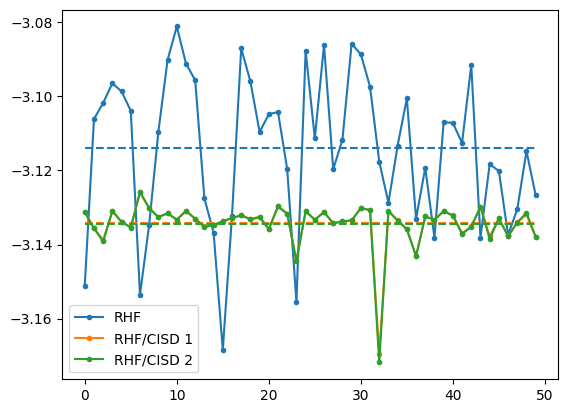

In [40]:
from matplotlib import pyplot as plt
ehf_avg = ehf_sp_list.mean()
ehf_avg_std = np.std(ehf_sp_list, ddof=1) / np.sqrt(len(ehf_sp_list))
eci_avg = eci_sp_list.mean()
eci_avg_std = np.std(eci_sp_list, ddof=1) / np.sqrt(len(eci_sp_list))
eci2_avg = eci2_sp_list.mean()
eci2_avg_std = np.std(eci2_sp_list, ddof=1) / np.sqrt(len(eci2_sp_list))
print(f'AFQMC/RHF average = {ehf_avg}, std = {ehf_avg_std}')
print(f'AFQMC/CISD_RHF method1 average = {eci_avg}, std = {eci_avg_std}')
print(f'AFQMC/CISD_RHF method2 average = {eci2_avg}, std = {eci2_avg_std}')
plt.plot(ehf_sp_list,'.-',label='RHF',color='C0')
plt.plot([ehf_avg]*len(ehf_sp_list),'--',color='C0')
plt.plot(eci_sp_list,'.-',label='RHF/CISD 1',color='C1')
plt.plot([eci_avg]*len(eci_sp_list),'--',color='C1')
plt.plot(eci2_sp_list,'.-',label='RHF/CISD 2',color='C2')
plt.plot([eci2_avg]*len(eci2_sp_list),'--',color='C2')
plt.legend()
plt.show()

In [41]:
# CISD
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 50,
            'seed': 2,
            'walker_type': 'rhf',
            'trial': 'cisd',
            'dt':0.005,
            'free_projection':False,
            'ad_mode':None,
            'use_gpu': False,
            }

# prop_unrestricted.run_afqmc(options,nproc=1)
option_file='options.bin'
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (
    prop_unrestricted._prep_afqmc())

init_time = time.time()
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

### initialize propagation
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)
h0 = ham_data['h0']

prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    raise ValueError(
        "Initial overlaps are zero. Pass walkers with non-zero overlap."
    )
prop_data["key"] = random.PRNGKey(seed + rank)

prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
prop_data["n_killed_walkers"] = 0
prop_data["pop_control_ene_shift"] = prop_data["e_estimate"]

comm.Barrier()
if rank == 0:
    e_init = prop_data["e_estimate"]
    print('# \n')
    print(f'# Propagating with {options["n_walkers"]*size} walkers')
    print("# Equilibration sweeps:")
    print("#   Iter \t energy \t Walltime")
    print(f"  {0:5d} \t {e_init:.6f} \t {time.time() - init_time:.2f}")
comm.Barrier()

sampler_eq = sampling.sampler(
    n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10, n_chol = sampler.n_chol)
ecisd_eq_list = np.empty(options['n_eql'])

for i,n in enumerate(range(1,options["n_eql"]+1)):
    prop_data, (wt, ecisd) = sampler_eq.propagate_phaseless(
        ham, ham_data, prop, prop_data, trial, wave_data)
    ecisd_eq_list[i] = ecisd
    print(f"  {n:5d} \t {ecisd:.6f} \t {time.time() - init_time:.2f}")

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 6
# nelec: (3, 3)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 50
# seed: 2
# walker_type: rhf
# trial: cisd
# dt: 0.005
# free_projection: False
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# 

# Propagating with 50 walkers
# Equilibration sweeps:
#   Iter 	 energy 	 Walltime
      0 	 -3.136031 	 0.80
      1 	 -3.133661 	 2.98
      2 	 -3.134085 	 5.56
      3 	 -3.136759 	 6.76


In [42]:
nsamples = 50
ecisd_sp_list = np.empty(nsamples)
for i,n in enumerate(range(1,nsamples+1)):
    prop_data, (wt, ecisd)  =\
        sampler.propagate_phaseless(
            ham, ham_data, prop, prop_data, trial, wave_data)
    ecisd_sp_list[i] = ecisd
    print(f"  {n:5d} \t {ecisd:.6f} \t {time.time() - init_time:.2f}")

      1 	 -3.139027 	 9.99
      2 	 -3.134840 	 10.11
      3 	 -3.136060 	 10.23
      4 	 -3.132106 	 10.37
      5 	 -3.139585 	 10.49
      6 	 -3.149708 	 10.62
      7 	 -3.130313 	 10.74
      8 	 -3.142530 	 10.88
      9 	 -3.138975 	 11.01
     10 	 -3.130861 	 11.14
     11 	 -3.134123 	 11.28
     12 	 -3.132885 	 11.40
     13 	 -3.132241 	 11.54
     14 	 -3.133249 	 11.67
     15 	 -3.135547 	 11.79
     16 	 -3.134190 	 11.92
     17 	 -3.135414 	 12.04
     18 	 -3.132974 	 12.16
     19 	 -3.136117 	 12.29
     20 	 -3.135914 	 12.41
     21 	 -3.138689 	 12.54
     22 	 -3.132692 	 12.66
     23 	 -3.133906 	 12.79
     24 	 -3.135339 	 12.92
     25 	 -3.131633 	 13.07
     26 	 -3.137508 	 13.20
     27 	 -3.131099 	 13.32
     28 	 -3.133086 	 13.44
     29 	 -3.133928 	 13.58
     30 	 -3.135664 	 13.71
     31 	 -3.131595 	 13.84
     32 	 -3.131794 	 13.97
     33 	 -3.159038 	 14.11
     34 	 -3.141874 	 14.23
     35 	 -3.136039 	 14.37
     36 	 -3.137891 	

AFQMC/RHF average = -3.113965225002443, std = 0.0028988438114736447
AFQMC/CISD_RHF method1 average = -3.1342542528071875, std = 0.0008514503016117166
AFQMC/CISD_RHF method2 average = -3.1343296624216737, std = 0.0008953228931924749
AFQMC/CISD Original method2 average = -3.1360319841844557, std = 0.0007624176169125136


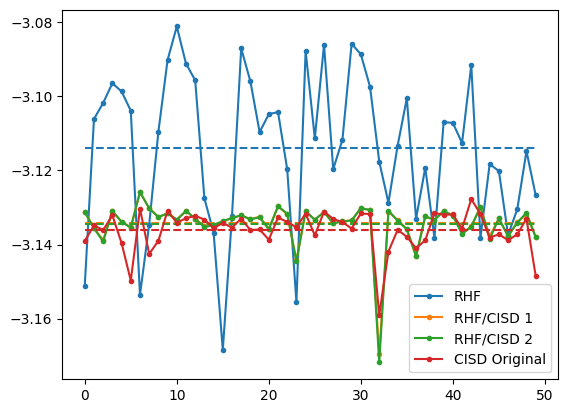

In [43]:
from matplotlib import pyplot as plt
ehf_avg = ehf_sp_list.mean()
ehf_avg_std = np.std(ehf_sp_list, ddof=1) / np.sqrt(len(ehf_sp_list))
eci_avg = eci_sp_list.mean()
eci_avg_std = np.std(eci_sp_list, ddof=1) / np.sqrt(len(eci_sp_list))
eci2_avg = eci2_sp_list.mean()
eci2_avg_std = np.std(eci2_sp_list, ddof=1) / np.sqrt(len(eci2_sp_list))
ecisd_avg = ecisd_sp_list.mean()
ecisd_avg_std = np.std(ecisd_sp_list, ddof=1) / np.sqrt(len(ecisd_sp_list))
print(f'AFQMC/RHF average = {ehf_avg}, std = {ehf_avg_std}')
print(f'AFQMC/CISD_RHF method1 average = {eci_avg}, std = {eci_avg_std}')
print(f'AFQMC/CISD_RHF method2 average = {eci2_avg}, std = {eci2_avg_std}')
print(f'AFQMC/CISD Original method2 average = {ecisd_avg}, std = {ecisd_avg_std}')
plt.plot(ehf_sp_list,'.-',label='RHF',color='C0')
plt.plot([ehf_avg]*len(ehf_sp_list),'--',color='C0')
plt.plot(eci_sp_list,'.-',label='RHF/CISD 1',color='C1')
plt.plot([eci_avg]*len(eci_sp_list),'--',color='C1')
plt.plot(eci2_sp_list,'.-',label='RHF/CISD 2',color='C2')
plt.plot([eci2_avg]*len(eci2_sp_list),'--',color='C2')
plt.plot(ecisd_sp_list,'.-',label='CISD Original',color='C3')
plt.plot([ecisd_avg]*len(ecisd_sp_list),'--',color='C3')
plt.legend()
plt.show()